# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, RocCurveDisplay

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    """
    YOUR CODE IS HERE
    """
    
    derivative = np.array(2 * np.sin(w) * np.cos(w))
    return derivative

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w)  #  YOUR CODE. Не забудьте про lr!

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

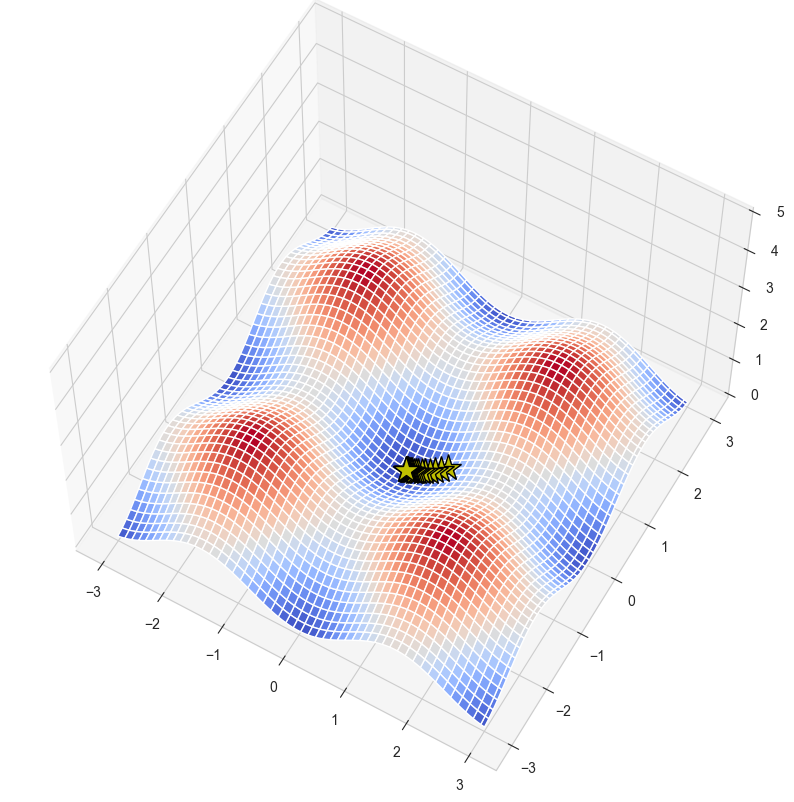

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

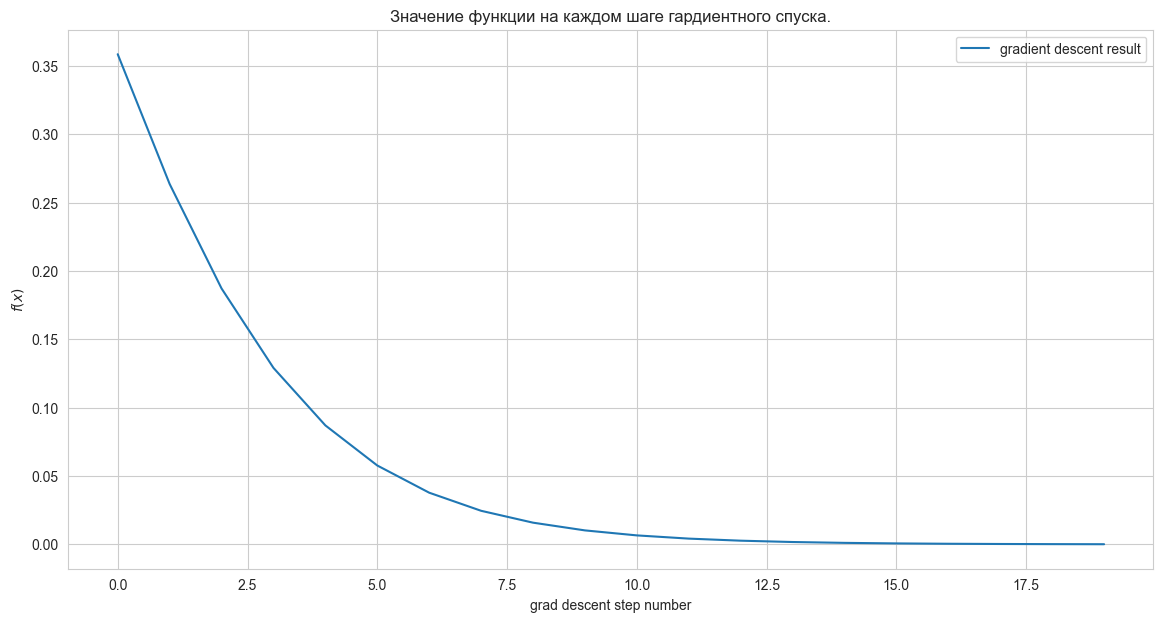

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    """
    YOUR CODE IS HERE
    """

    total_number = y_true.shape[0]
    # Безматричный вариант
    # mse = np.sum((y_true - y_pred)**2) / total_number 
    mse = ((y_true - y_pred).transpose() @ (y_true - y_pred)) / total_number  # Список в списке
    return mse
    

def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    """
    YOUR CODE IS HERE
    """
    
    total_number = y_true.shape[0]
    grad_mse = 2 * (X.transpose() @ (y_pred - y_true)) / total_number
    return grad_mse


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        """
        YOUR CODE IS HERE
        """
         
        prediction = X_test @ self.W
        return prediction
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

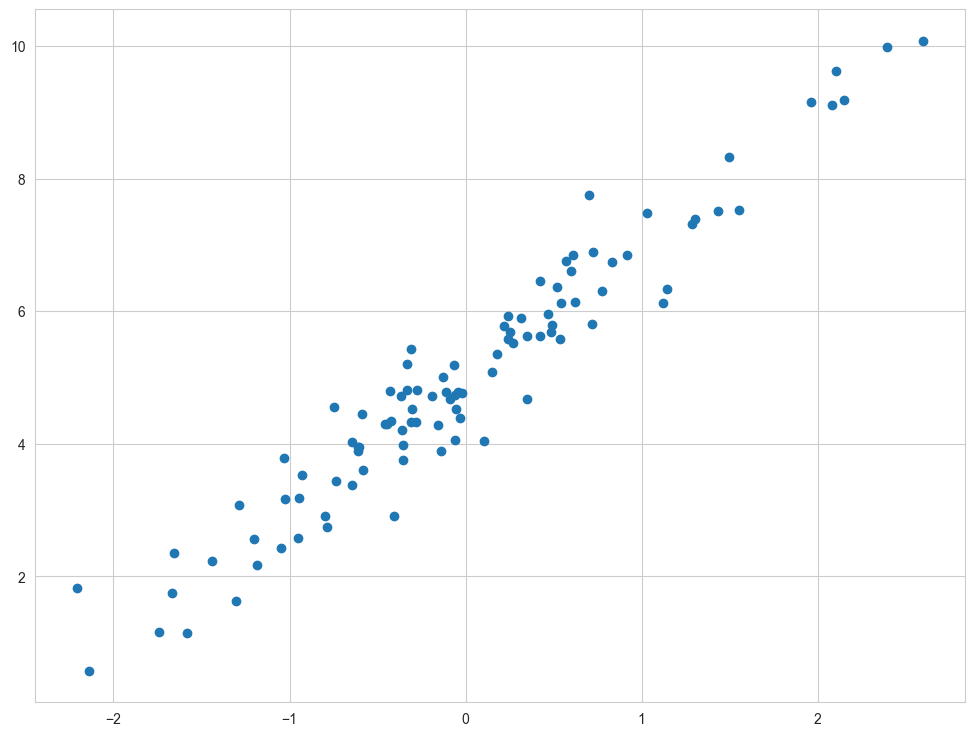

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

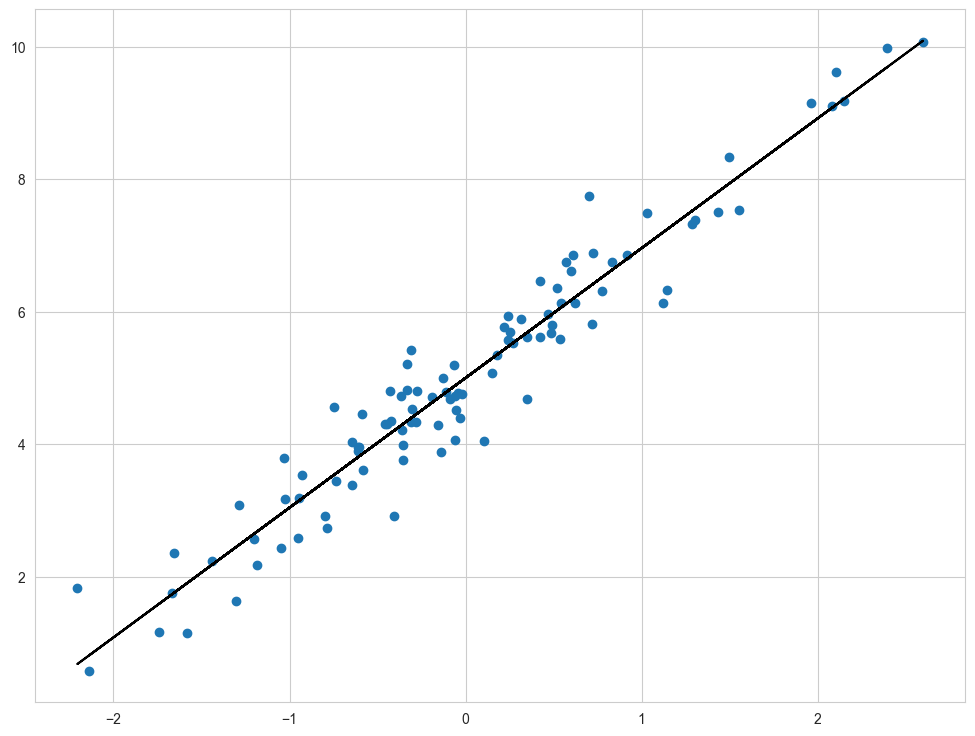

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X), color='black');

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

**EDA**

In [20]:
# Количество строк - 20640, количество признаков - 8
X.shape

(20640, 8)

In [21]:
print(feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Всего в данных присутствует 8 перменных. Все они являются количественными:
1. MedInc median income in block group
2. HouseAge median house age in block group
3. AveRooms average number of rooms per household
4. AveBedrms average number of bedrooms per household
5. Population block group population
6. AveOccup average number of household members
7. Latitude block group latitude
8. Longitude block group longitude

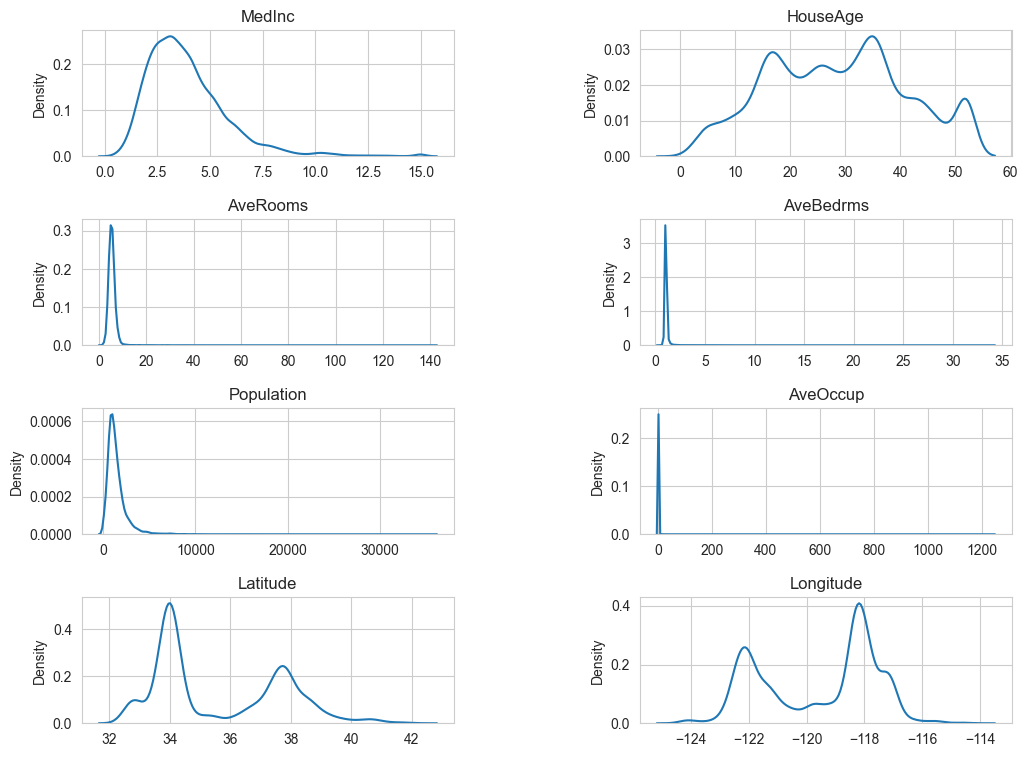

In [22]:
# Анализируем распределение данных

for i in range(8):
    plt.subplot(4, 2, i + 1)
    sns.kdeplot(X[:, i])
    plt.title(feature_names[i])
plt.subplots_adjust(wspace=0.5, hspace=0.5)


Ни один из перечисленных признаков не рапределён нормально. В нашем датасете достаточное количество наблюдений, чтобы этим пренебречь. Есть большой спектр уникальных наблюдений в AveRooms, AveBedrms, Population и AveOccupОднако, однако это объясняется спецификой различных домов (всё-таки это Калифорния!). Есть опасение, что при удалении данных уникальных значений, мы потеряем большое количество информации, специфичной именно для данной террритории.

Все признаки распределены в разных диапазонах значений. Чтобы снизить влияние дисперсий на предсказание модели, обязательно данные стандартизуем. Выполняю стандартизацию ниже.

In [23]:
# Создаю датафрейм для более удобной работы с данными

real_estate_calif = pd.DataFrame()
for i in range(8):
    column = pd.DataFrame(data=X[:, i], columns=[feature_names[i]])
    real_estate_calif = pd.concat((real_estate_calif, column), axis=1)

In [24]:
real_estate_calif.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [25]:
# Анализирую количество пропущенных значений

real_estate_calif.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [26]:
# Анализирую количество 0 (в наших данных 0 не имеет смысла)

real_estate_calif[real_estate_calif == 0].count()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

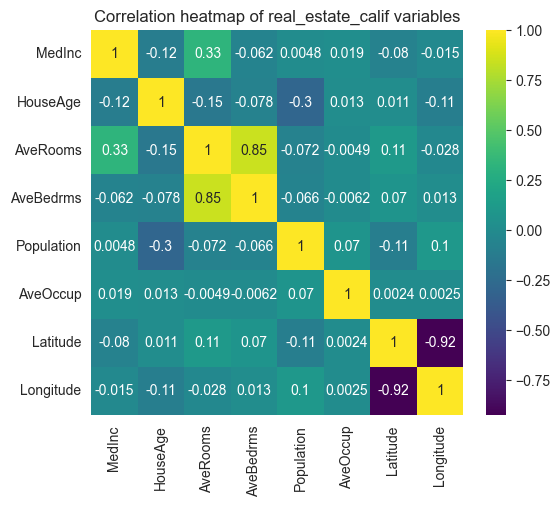

In [27]:
# Оцениваю степень корреляции между всеми признаками

figure = plt.figure(figsize=(6, 5))
sns.heatmap(real_estate_calif.corr(), cmap=sns.color_palette("viridis", as_cmap=True), annot=True)
plt.title('Correlation heatmap of real_estate_calif variables')
plt.show()

В итоге анализа, в данных очень сильно коррелируют среднее количество комнат(AveRooms) и количество спален(AveBedrms) со значением корреляции 0.85. Также существует обратная корреляция между долготой (Longitude) и широтой (Latitude). Коэффициент корреляции составляет -0.92

Для того, чтобы соблюсти принцип отсутствия коллинеарности удалим признаки Longitude и AveRooms

In [28]:
X = real_estate_calif.drop(columns=['AveRooms', 'Longitude'])
X.head()

,MedInc,HouseAge,AveBedrms,Population,AveOccup,Latitude
0,8.3252,41.0,1.023810,322.0,2.555556,37.88
1,8.3014,21.0,0.971880,2401.0,2.109842,37.86
2,7.2574,52.0,1.073446,496.0,2.802260,37.85
3,5.6431,52.0,1.073059,558.0,2.547945,37.85
4,3.8462,52.0,1.081081,565.0,2.181467,37.85


**Разделяем группы на train и test**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

**Строим модель линейной регрессии**

In [30]:
# Строим pipeline
lm_pipeline = Pipeline(steps=[
    ('num_scaler', StandardScaler()),
    ('lin_reg', LinearRegression())
])

# Обучаем модель 
lm_pipeline.fit(X_train, y_train)

# Получаем предсказания для выборки test
y_test_pred = lm_pipeline.predict(X_test)

# Получаем предсказания для выборки train
y_train_pred = lm_pipeline.predict(X_train)

**Анализируем качество модели**

In [31]:
# Метрики для test выборки
r_2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f'R2 is {r_2}')
print(f'MSE is {mse}')

R2 is 0.5103351741460125
MSE is 0.6586749623319865


In [32]:
# Метрики для train выборки
r_2 = r2_score(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
print(f'R2 is {r_2}')
print(f'MSE is {mse}')

R2 is 0.5226002790900806
MSE is 0.6334519032879056


In [33]:
# Анализируем распределение остатков
residuals = y_test - y_test_pred

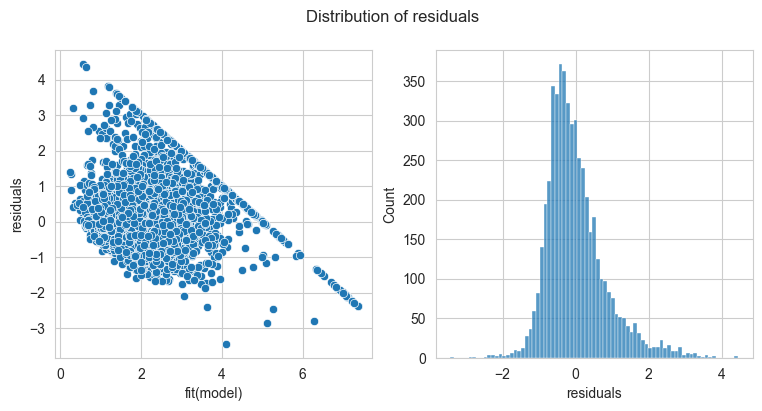

In [34]:
# Строим графики для более удобного анализа
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

plt.suptitle('Distribution of residuals')
sns.scatterplot(x=y_test_pred, y=residuals, ax=axes[0])
axes[0].set_xlabel('fit(model)')
axes[0].set_ylabel('residuals')

sns.histplot(residuals, ax=axes[1])
axes[1].set_xlabel('residuals');

In [35]:
# Анализируем полученные коэффициенты модели
coef = pd.Series(lm_pipeline[1].coef_)
names = pd.Series(X.columns)
df_coef = pd.concat((names, coef), axis=1).rename(columns={0: 'Feature', 1: 'Coef'})

In [36]:
# Intercept
lm_pipeline[1].intercept_

2.0627275264857885

In [37]:
# Остальные коэффициенты
display(df_coef)

,Feature,Coef
0,MedInc,0.815972
1,HouseAge,0.229929
2,AveBedrms,0.012799
3,Population,0.026097
4,AveOccup,-0.053982
5,Latitude,-0.100317


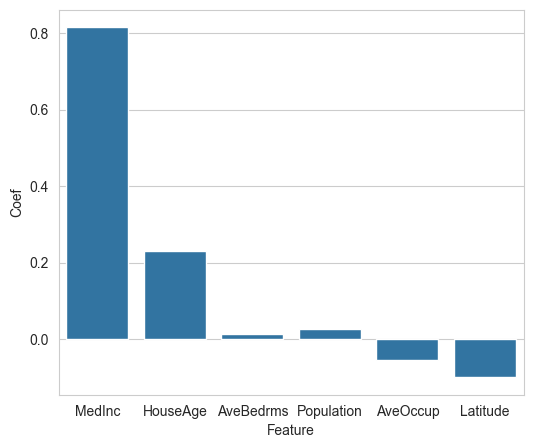

In [38]:
# Визуализируем для удобства
figure = plt.figure(figsize=(6, 5))
sns.barplot(x=df_coef['Feature'], y=df_coef['Coef']);

**Делаем выводы**
- Качество полученной модели

В целом, мы получили модель со средними показателями. Исходя из показателя r2, мы можем утверждать, что только в 51-52 % случаев дисперсия цен обусловлена дисперсией выбранных признаков.

Также, в рамках данной модели не соблюдаются некоторые условия применимости. По гистограмме распределения, мы можем сказать, что, в целом, остатки модели распределены нормально. Однако по диаграмме рассеивания однозначно не выполняется правило гомоскедастичности.

- Наиболее значимые признаки

Исходя из полученных коэффициентов модели, наибольшее влияние на предсказание оказывает медианные показатели доходов MedInc (достаточно логично). На втором месте оказался возраст дома. Третье по значимости - долгота Latitude. Данный результат тоже достаточно логичен, так как само расположения жилья очень влияет на спрос. В Калифорнии это особенно актуально)

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [39]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    """
    YOUR CODE IS HERE
    """
    
    sig = 1 / (1 + np.exp(-output))
    return sig

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [40]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    """
    YOUR CODE IS HERE
    """
    sig = 1 / (1 + np.exp(-y_pred))
    bce_value = - np.sum((y_true * np.log(sig)) + ((1 - y_true) * np.log(1 - sig))) / n
    return bce_value
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    """
    YOUR CODE IS HERE
    """
    sig = 1 / (1 + np.exp(-y_pred))
    bce_grad_val = X.transpose() @ (sig - y_true)
    return bce_grad_val


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [41]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        """
        YOUR CODE IS HERE
        """
        prediction = X_test @ self.W
        return prediction
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [42]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

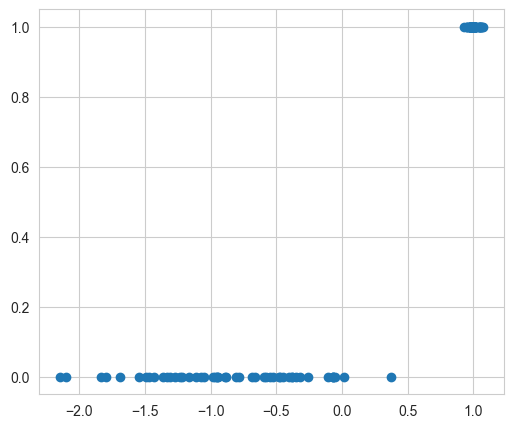

In [43]:
figure = plt.figure(figsize=(6, 5))
plt.scatter(X, y);

In [44]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

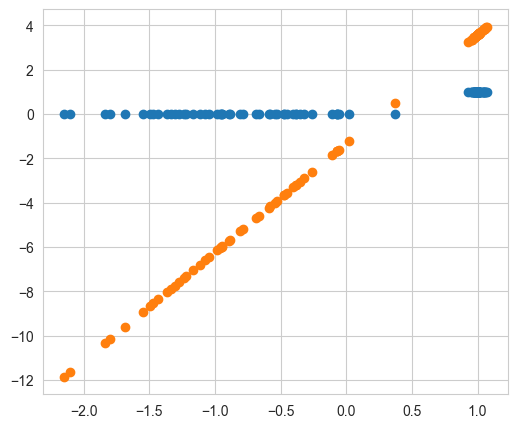

In [45]:
# Получается не совсем корректный график, так как здесь мы имеем дело с бинарной классификацией
figure = plt.figure(figsize=(6, 5))
plt.scatter(X, y)
plt.scatter(X, y_pred);

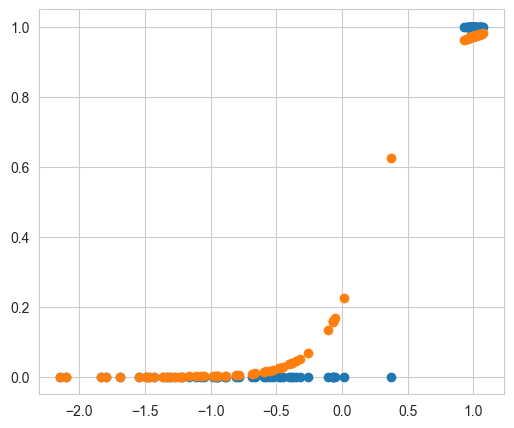

In [46]:
# Тут представлен корректный вывод логистической регрессии
figure = plt.figure(figsize=(6, 5))
plt.scatter(X, y)
plt.scatter(X, sigmoid(y_pred));

**Важно** 

При внесении преобразования сигмы в класс мы получаем более острый график. В данном случае происходит наложение функций сигма из BCE и градиента. Чтобы сигмоида корректно преобразовывала внутри класса, необходимо преобразованные значения в loss функции и градиенте оставить y_pred

In [47]:
# Переводим полученные предсказания в номинативные перменные
for number in range(y_pred.shape[0]):
    if y_pred[number] >= 0.5:
        y_pred[number] = 1
    elif y_pred[number] < 0.5:
        y_pred[number] = 0

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [48]:
# Считаю метрики
print(f'Accuracy is {accuracy_score(y, y_pred)}')
print(f'Precision is {precision_score(y, y_pred)}')
print(f'Recall is {recall_score(y, y_pred)}')
print(f'F1_score is {f1_score(y, y_pred)}')


Accuracy is 0.99
Precision is 0.9803921568627451
Recall is 1.0
F1_score is 0.9900990099009901


Все метрики бинарной классификации либо равны 1 либо приближены к ней, поэтому в данном случае мы получили хорошую модель классификации

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [49]:
pokemon = pd.read_csv("../data/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


**EDA**

In [50]:
# df имеет 800 строк и 12 признаков  
# Первая колонка содержит порядковый номер
pokemon.shape

(800, 13)

In [51]:
pokemon = pokemon.drop(columns=['#'])

In [52]:
pokemon.nunique()

Name          800
Type 1         18
Type 2         18
Total         200
HP             94
Attack        111
Defense       103
Sp. Atk       105
Sp. Def        92
Speed         108
Generation      6
Legendary       2
dtype: int64

В данном датафрейме:

1. Строковая переменна
- Name - уникально для каждого покемона

2. Количественные переменные 
- Total: sum of all stats, a general guide to how strong a pokemon
- HP: hit points, or health, defines how much damage a pokemon can withstand before fainting
- Attack: the base modifier for normal attacks (eg. Scratch, Punch)
- Defense: the base damage resistance against normal attacks
- SP Atk: special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)
- SP Def: the base damage resistance against special attacks
- Speed: determines which pokemon attacks first each round

3. Категориальные переменные
- Type 1: Each pokemon has a type, this determines weakness/resistance to attacks
- Type 2: Some pokemon are dual type and have 2
- Generation
- **Legendary** (наша целевая переменная)

In [53]:
# Разделяю колонки по переменным для дальнейшей работы 
num_col = ['Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed']

cat_col = ['Type 1', 'Type 2', 'Generation', 'Legendary']

In [54]:
pokemon.isna().sum()

Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

Не все покемоны имеют второй тип, поэтому данная колонка имеет наиболее количество пропущенных значений. Разумнее было бы заменить их на 0, так как отсутствие этого признака также несет необходимую информацию 

In [55]:
# Импутация
pokemon = pokemon.fillna('No')

In [56]:
pokemon.isna().sum()

Name          0
Type 1        0
Type 2        0
Total         0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
dtype: int64

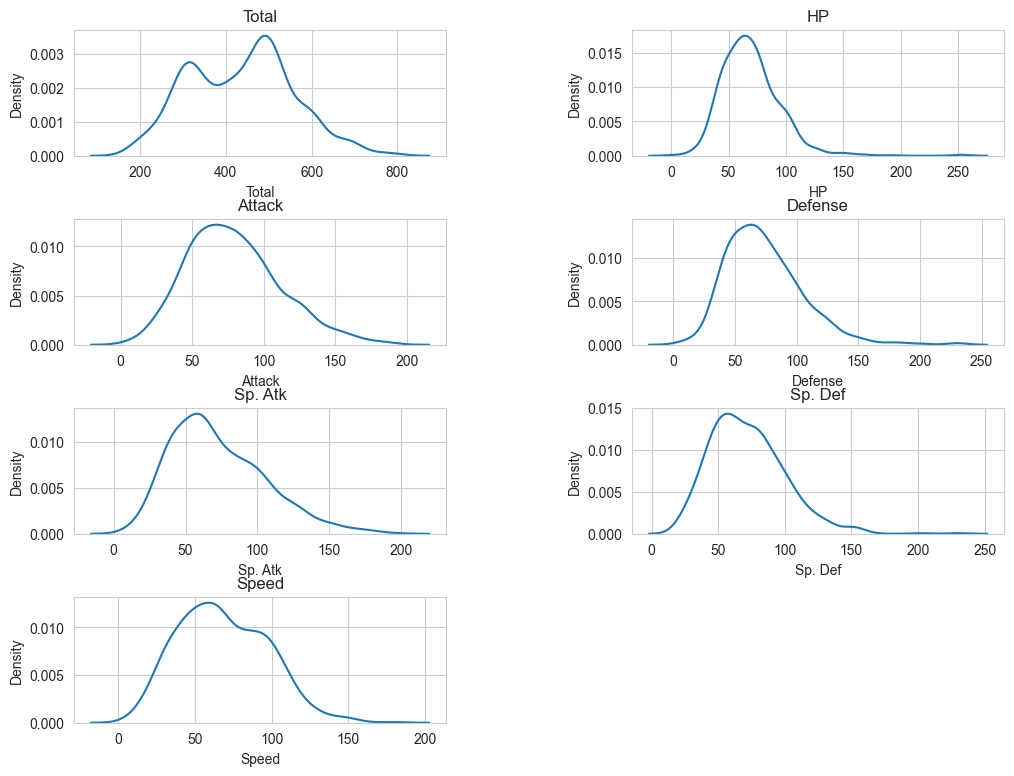

In [57]:
# Анализирую количественные переменные
i = 1
for name in num_col:
    plt.subplot(4, 2, i)
    sns.kdeplot(data=pokemon[name])
    plt.title(name)
    i += 1

plt.subplots_adjust(wspace=0.5, hspace=0.5)

Распределение количественных переменных близко к нормальному. Единственным отличием является Total, но тут также можем считать, что у нас достаточное количество наблюдений. Для снижения влияния дисперсии также стандартизуем (ниже в Pipeline)

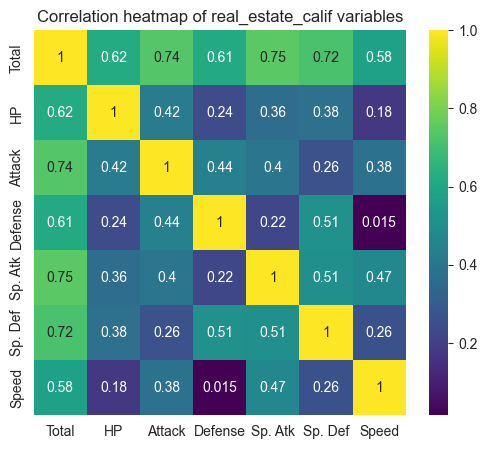

In [58]:
# Смотрим корреляцию между количественными переменными
figure = plt.figure(figsize=(6, 5))
sns.heatmap(pokemon[num_col].corr(), cmap=sns.color_palette("viridis", as_cmap=True), annot=True)
plt.title('Correlation heatmap of real_estate_calif variables')
plt.show()

Признак total собирает нам воедино все количественные перменные, поэтому она коррелирует со всеми значениями. Перед работой можем её удалить.

In [59]:
pokemon = pokemon.drop(columns=['Total'])

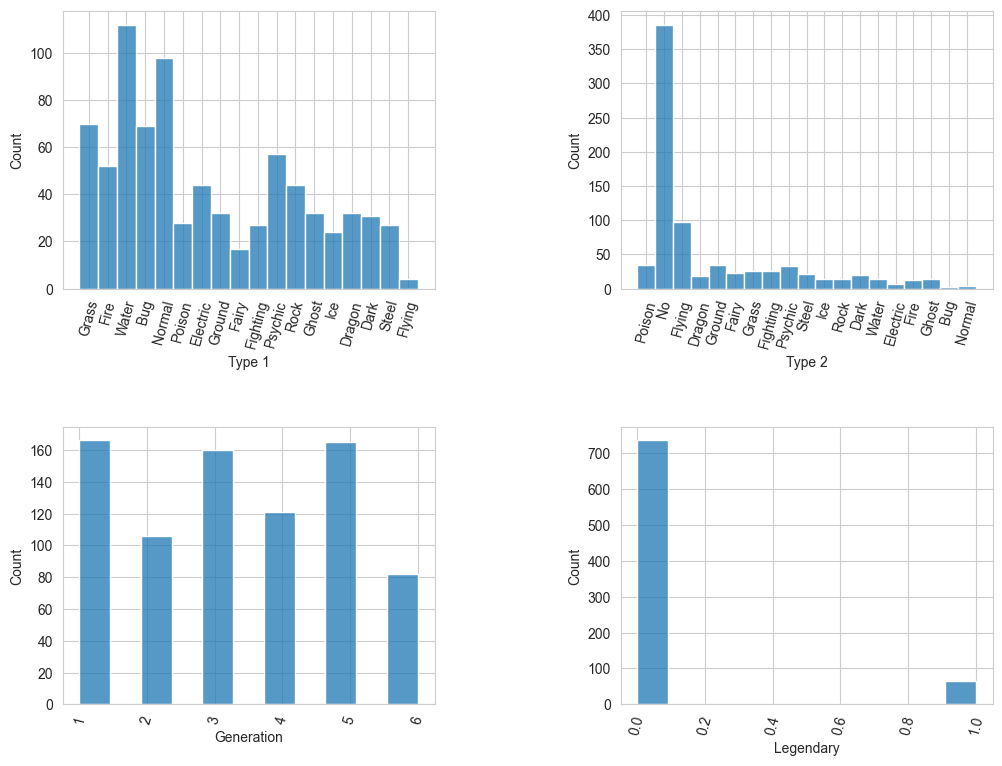

In [60]:
# Работаю с номинативными перменными
i = 1
for name in cat_col:
    plt.subplot(2, 2, i)
    sns.histplot(pokemon[name])
    plt.xticks(rotation=75)
    i += 1

plt.subplots_adjust(wspace=0.5, hspace=0.5)

Можем видеть, что классы очень сильно несбалансированы. Особенно второй тип - это не явдяется обязательной характеристикой для покемонов. Все их необходимо трансформировать перед работой.

**Важно** наш целевой класс тоже является несбалансированным. Это может сильно повлиять на предсказание нашей модели.

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [61]:
# Перекодирую значения целевой переменной в 0 и 1
pokemon['Legendary'] = pokemon['Legendary'].astype(int)

In [62]:
pokemon.Legendary.unique()

array([0, 1])

В целом, сам факт того, что переменная является категориальной, не является причиной её выкинуть. Других указаний, почему необходимо их удалить, я не вижу. 

Важно эти данные трансформировать перед работой - выполню это в Pipeline

Разделите ваши данные на тестовую и тренировочную выборку.

In [63]:
# Создаю раздельные датасеты 
X = pokemon.drop(columns='Legendary')
y = pokemon['Legendary']

# Разделяю на выборки 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

Обучите модель `LogisticRegression` из `sklearn`.

In [64]:
# Дублирую колонки, так как некоторые были выкинуты

num_col = ['HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed']

cat_col = ['Type 1', 'Type 2', 'Generation']
# Строим наш трансформер 
preprocessor = ColumnTransformer(transformers=[
    ('num_scaler', StandardScaler(), num_col),
    ('cat_ohe', OneHotEncoder(drop='first'), cat_col)
])

# Строим pipeline
glm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('glm_reg', LogisticRegression())
])

# Обучаем модель 
glm_pipeline.fit(X_train, y_train)

# Получаем предсказания для выборки test
y_test_pred = glm_pipeline.predict(X_test)

# Получаем предсказания для выборки train
y_train_pred = glm_pipeline.predict(X_train)

In [65]:
# Достаточно высокие метрики
accuracy_test = accuracy_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)

print(f'Acurracy on test dataset is {accuracy_test}')
print(f'Acurracy on train dataset is {accuracy_train}')

Acurracy on test dataset is 0.93125
Acurracy on train dataset is 0.9640625


Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

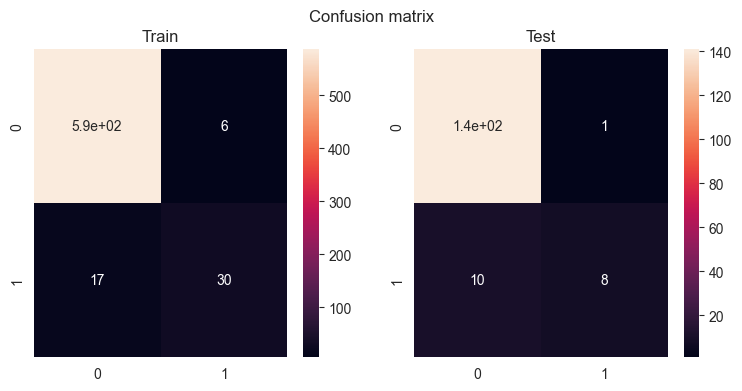

In [66]:
# Confusion matrix
cf_train = confusion_matrix(y_train, y_train_pred)
cf_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

plt.suptitle('Confusion matrix')
sns.heatmap(cf_train, ax=axes[0], annot=True)
axes[0].set_title('Train')

sns.heatmap(cf_test, ax=axes[1], annot=True)
axes[1].set_title('Test');

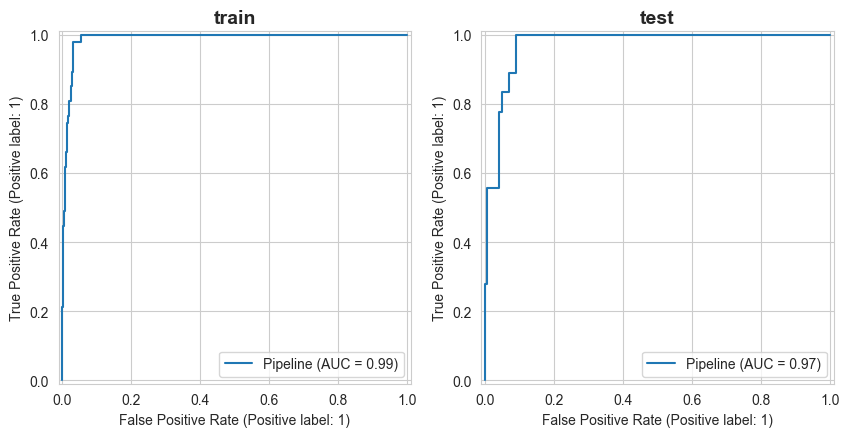

In [67]:
# Строю ROC-curve и анализирую результаты

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

RocCurveDisplay.from_estimator(glm_pipeline, X_train, y_train, ax=axes[0])
axes[0].set_title("train", size=14, weight='bold')

RocCurveDisplay.from_estimator(glm_pipeline, X_test, y_test, ax=axes[1])
axes[1].set_title("test", size=14, weight='bold');

In [68]:
# Выполняю отдельно подсчёт площади под кривой 
roc_auc_score_test = roc_auc_score(y_test, glm_pipeline.predict_proba(X_test)[:, 1])
roc_auc_score_train = roc_auc_score(y_train, glm_pipeline.predict_proba(X_train)[:, 1])
print(f'Test data has ROC_AUC {roc_auc_score_test}')
print(f'Train data has ROC_AUC {roc_auc_score_train}')

Test data has ROC_AUC 0.971830985915493
Train data has ROC_AUC 0.9887696889239711


**Вывод**

Исходя из полученных confusion_matrix и roc_auc мы получили достаточно хорошую модель. Если исходить из площади под ROC кривой, модель очень хорошо предсказывает. Однако, тут есть подвох. Она с высокой точностью предсказывает FP значения, так как исходно у нас была очень несбалансированная выборка. Так как исходно у нас был сдвиг в сторону нелегендарных покемонов, предсказание модели свинуто в их сторону. Это не есть хорошо.

In [69]:
# Анализирую вклад предикторов
coef_glm = pd.Series(glm_pipeline[1].coef_[0])
names_glm = pd.Series(glm_pipeline[:-1].get_feature_names_out())
df_coef_glm = pd.concat((names_glm, coef_glm), axis=1).rename(columns={0: 'Feature', 1: 'Coef'})

In [70]:
display(df_coef_glm)

,Feature,Coef
0,num_scaler__HP,0.753618
1,num_scaler__Attack,0.651914
2,num_scaler__Defense,1.045949
3,num_scaler__Sp. Atk,1.296445
4,num_scaler__Sp. Def,1.238557
5,num_scaler__Speed,1.219731
6,cat_ohe__Type 1_Dark,-0.278083
7,cat_ohe__Type 1_Dragon,-0.388561
8,cat_ohe__Type 1_Electric,0.070836
9,cat_ohe__Type 1_Fairy,-0.095240


In [71]:
df_coef_glm.nlargest(5, columns=['Coef'])

,Feature,Coef
44,cat_ohe__Generation_5,1.318664
3,num_scaler__Sp. Atk,1.296445
4,num_scaler__Sp. Def,1.238557
5,num_scaler__Speed,1.219731
2,num_scaler__Defense,1.045949


In [72]:
df_coef_glm.nsmallest(3, columns=['Coef'])

,Feature,Coef
22,cat_ohe__Type 1_Water,-0.854559
17,cat_ohe__Type 1_Normal,-0.810766
32,cat_ohe__Type 2_Ground,-0.679409


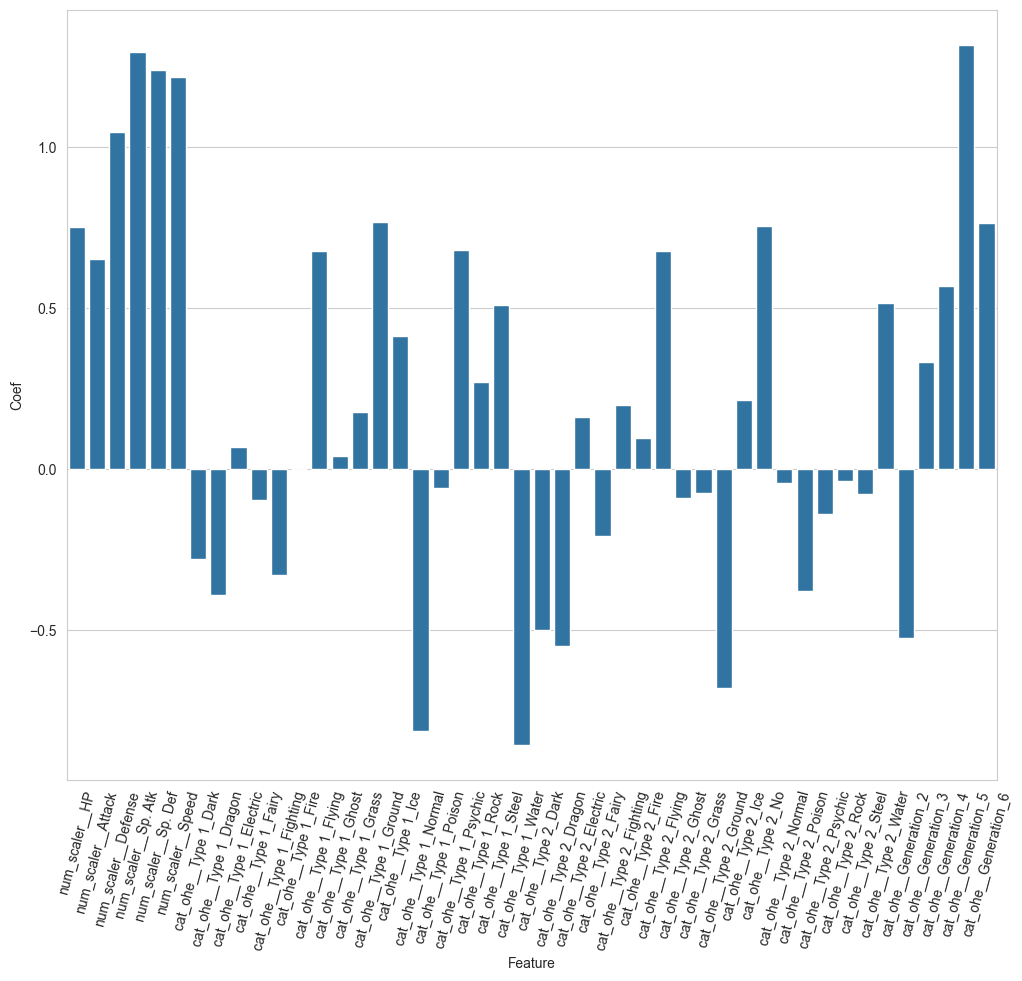

In [73]:
figure = plt.figure(figsize=(12, 10))
sns.barplot(x=df_coef_glm['Feature'], y=df_coef_glm['Coef'])
plt.xticks(rotation=75);

**Вывод**

Наибольшим весом обладают специальные навыки в сочетании со стандартной скоростью и защитой. Интересно, что отношение к 5 поколению вносит значительный вклад по отношению к покемонам из 1 поколения (он тут представлен, как базовый класс).

**Небольшое дополнение**

Меня всё-таки смутило такое количество предикторов. Попробовала удалить признак Type 2 или перекодировать его в Yes, No. Значительного повышения качества модели я не получила. Поэтому, не стала добавлять в ноутбук.

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Золото

Услышала его песню с отсылкой на Земфиру (ещё есть на Шуру). Он кайф

[Номер 1 Земфира](https://music.yandex.ru/album/7214040/track/51618087)

[Номер 2](https://music.yandex.ru/album/12997530/track/74363794)


## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**